In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from collections import defaultdict,Counter
from rdkit.Chem import AllChem
import pickle

from ChemTopicModel import chemTopicModel, utilsEvaluation, drawTopicModel

import sklearn
from rdkit import rdBase
import matplotlib as mpl

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

print('RDKit version: ',rdBase.rdkitVersion)
print('Pandas version:', pd.__version__)
print('Scikit-Learn version:', sklearn.__version__)
print('Numpy version:', np.__version__)
print('MatplotLib version:', mpl.__version__)
print('Seaborn version',sns.__version__)

RDKit version:  2018.09.2
Pandas version: 0.24.1
Scikit-Learn version: 0.20.2
Numpy version: 1.16.2
MatplotLib version: 3.0.2
Seaborn version 0.9.0


In [2]:
%matplotlib inline

### Load the data

Load the subtopic data from the original ChEMBL23 topic model (topic 61)

In [3]:
subTopicData = pd.read_csv('../TMChembl23_61subtopic.csv')

In [4]:
subTopicData.shape

(14288, 3)

### Build a sub topic model

In [5]:
subTopicModel=chemTopicModel.ChemTopicModel(sizeSampleDataSet=1.0, fragmentMethod='Morgan',n_jobs=10, 
                                               chunksize=1000, verbose=0, rareThres=0.001, commonThres=0.5)

In [6]:
subTopicModel.loadData(subTopicData)

In [7]:
import time

In [8]:
stime = time.time()
subTopicModel.generateFragments()
print("Time:", time.time()-stime)

Time: 132.6467616558075


In [9]:
subTopicModel.fragM.shape

(14288, 2557)

Build the topic model using 100 topics

In [10]:
numTopics=100
stime = time.time()
subTopicModel.buildTopicModel(numTopics, max_iter=50, nJobs=1, lowerPrecision=True)
print("Time:", time.time()-stime)

Time: 31.61859107017517


### Calculate the different metrics to explore the topic model in more detail

In [11]:
numTopics, numDocs = subTopicModel.getTopicFragmentProbabilities().shape

In [12]:
numTopicsMol=[]
for i in range(numDocs):
    numTopicsMol.append(len(Counter(subTopicModel.documentTopicProbabilities[i]))-1)

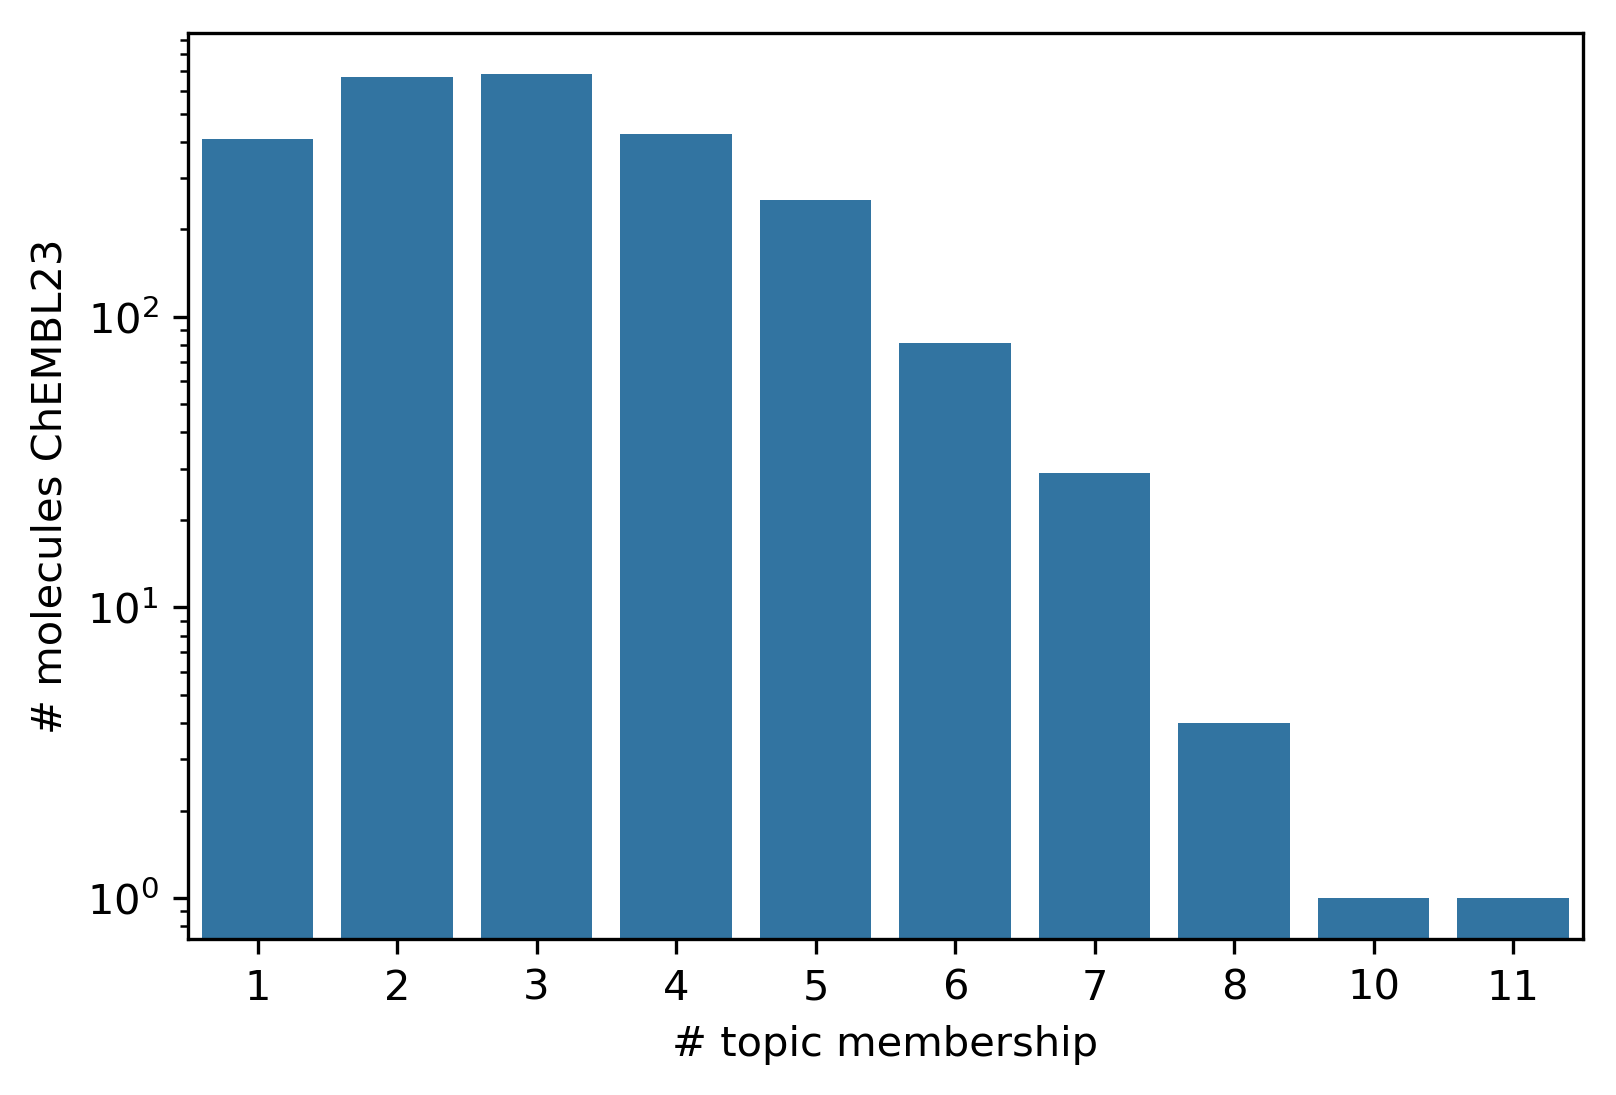

In [13]:
fig, ax = plt.subplots(1, dpi=300,)
sns.countplot(numTopicsMol, color=sns.color_palette()[0], ax=ax)
ax.set_yscale('log')
ax.set_ylabel('# molecules ChEMBL23')
ax.set_xlabel('# topic membership');
# fig.savefig('TopicMembershipChEMBL23.png', dpi=300, bbox_inches='tight')

In [14]:
from ChemTopicModel import utilsChemTM

In [15]:
ranking_result = utilsChemTM.rankInterestingTopics(subTopicModel, topXfrags=5)#, minMaxProb=0.15)

In [16]:
ranking_result = ranking_result.sort_values(['fraction high prob. mols'], ascending=False).reset_index(drop=True)

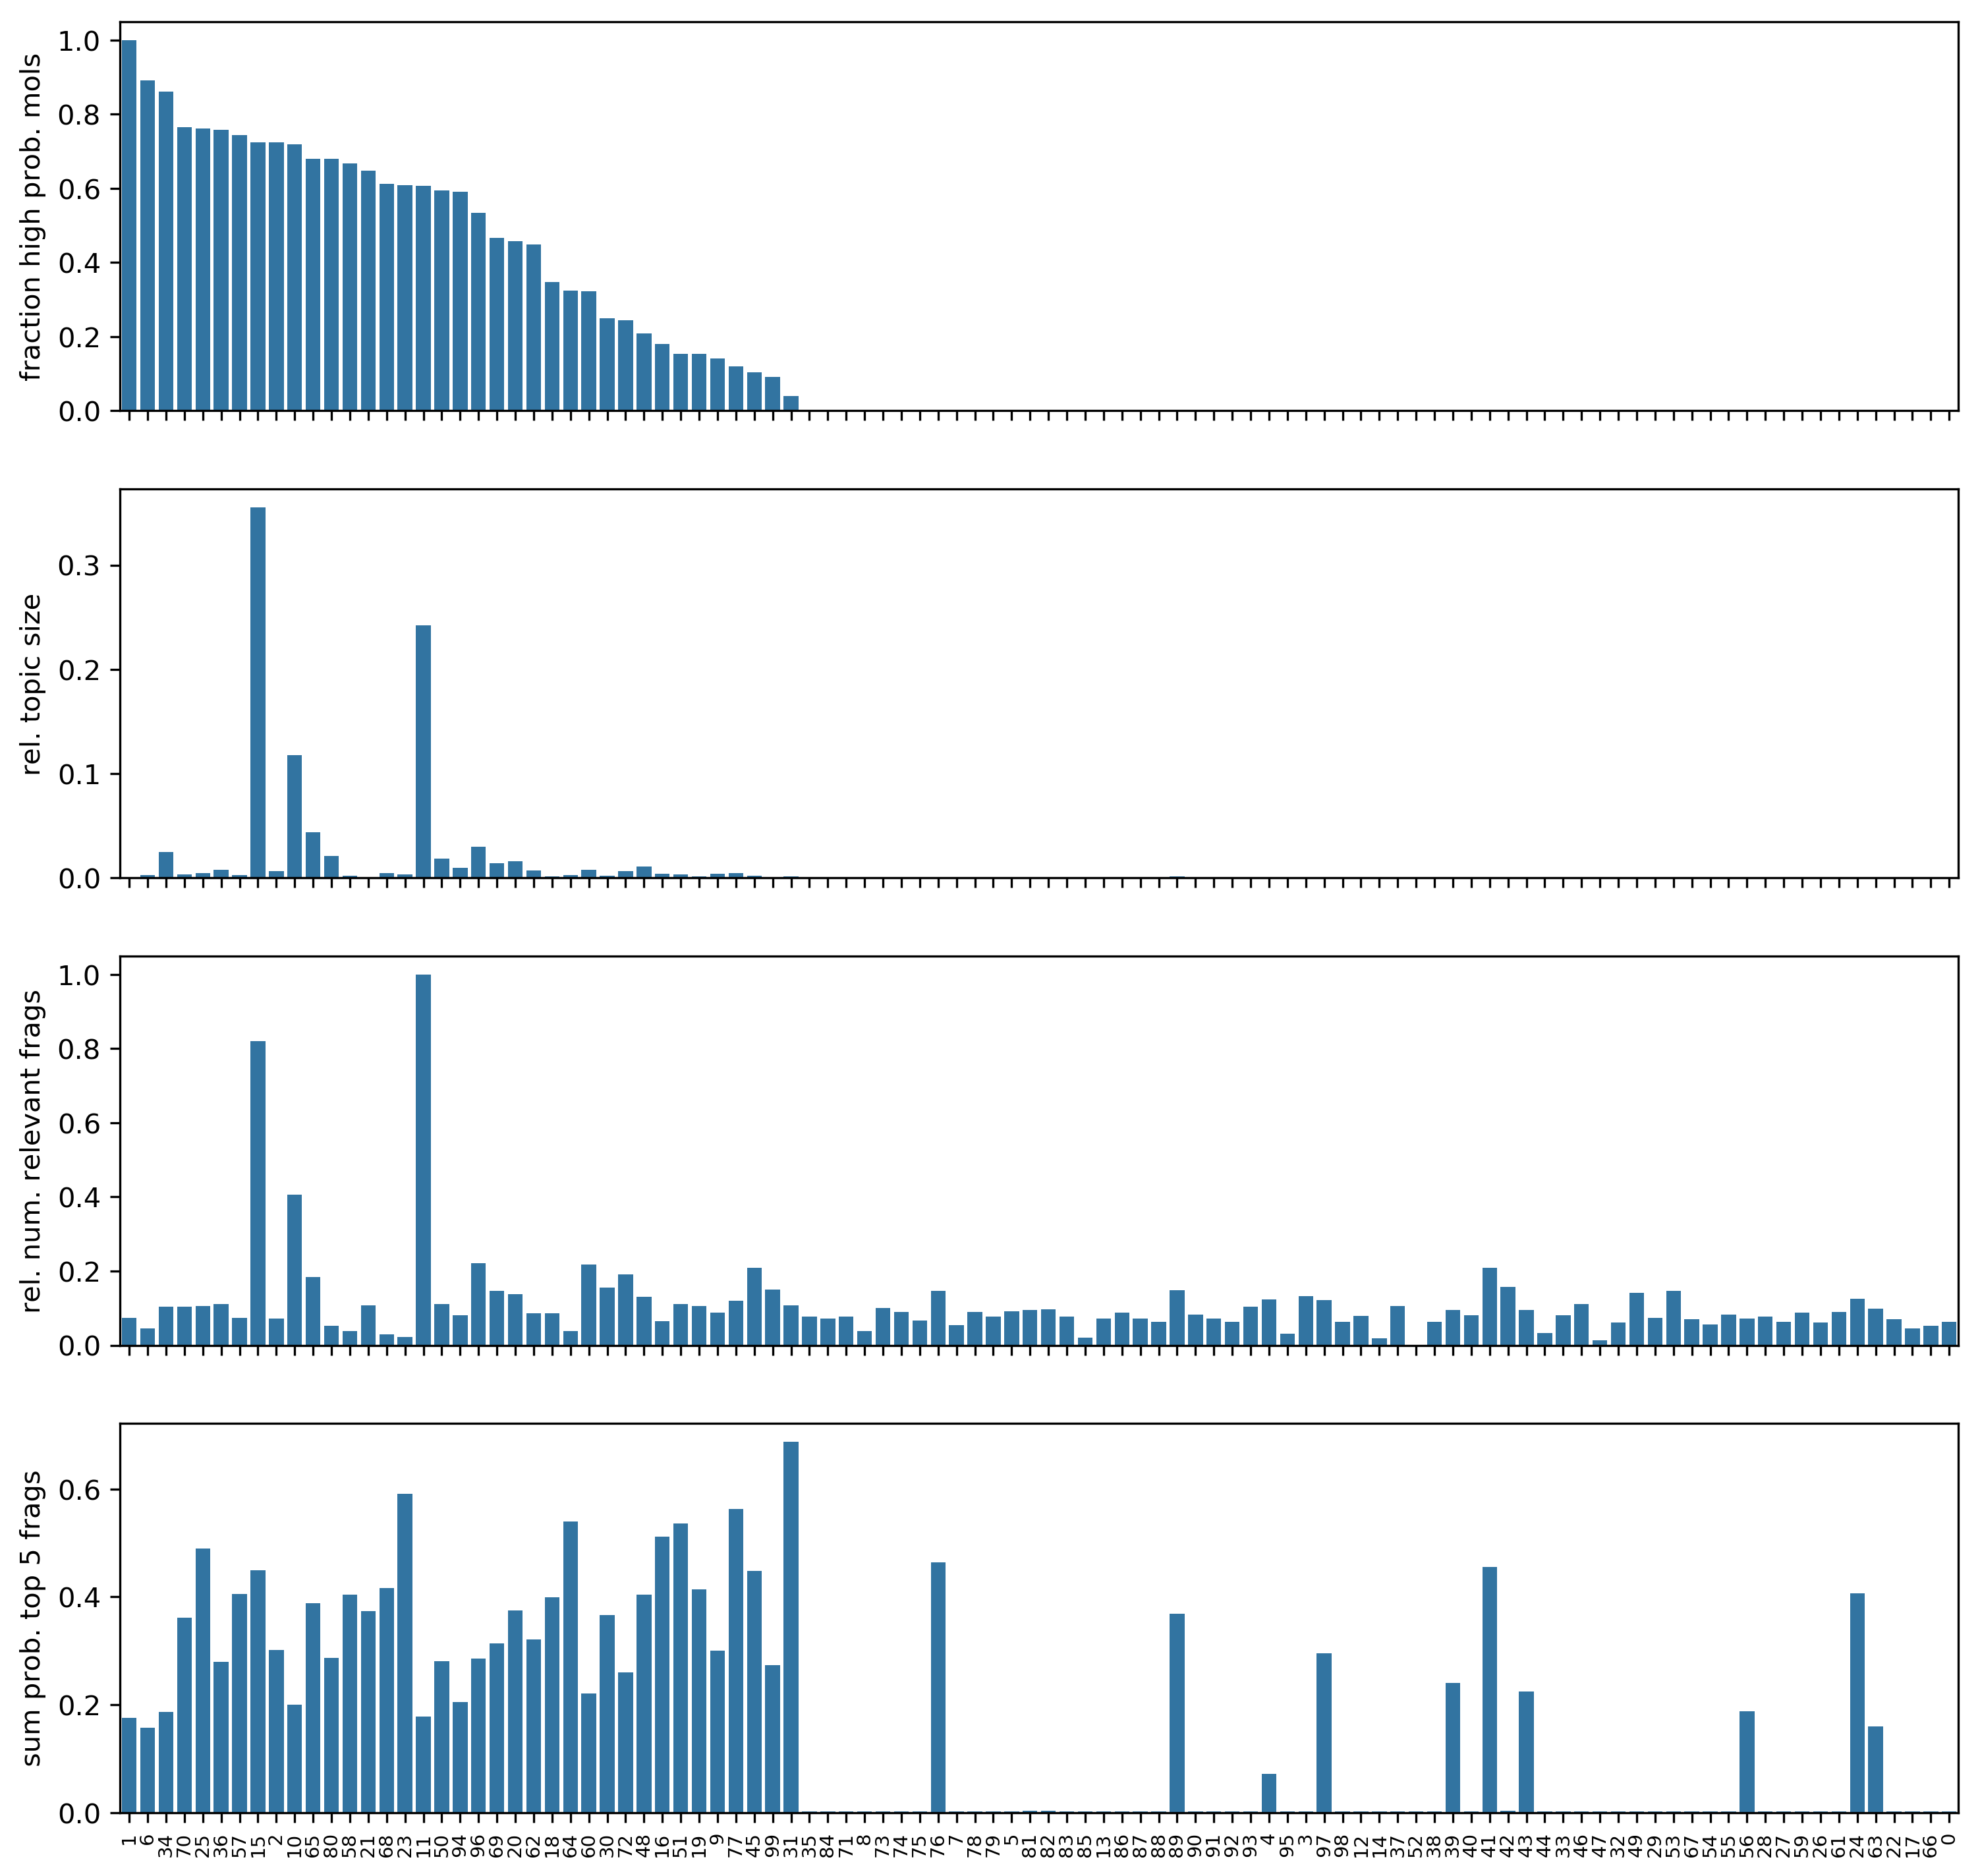

In [17]:
fig,ax=plt.subplots(4,1, figsize=(12,12),dpi=300)
sns.barplot(x=list(range(100)),y=ranking_result['fraction high prob. mols'],color=sns.color_palette()[0], ax=ax[0])
sns.barplot(x=list(range(100)),y=ranking_result['rel. topic size'],color=sns.color_palette()[0], ax=ax[1])
sns.barplot(x=list(range(100)),y=ranking_result['rel. num. relevant frags'],color=sns.color_palette()[0], ax=ax[2])
sns.barplot(x=list(range(100)),y=ranking_result['sum prob. top 5 frags'],color=sns.color_palette()[0], ax=ax[3])
plt.setp(ax[0].get_xticklabels(), visible=False)
plt.setp(ax[1].get_xticklabels(), visible=False)
plt.setp(ax[2].get_xticklabels(), visible=False)

_=ax[3].set_xticklabels(ranking_result['Topic Idx'],rotation=90,fontsize=7,verticalalignment='top')
fig.align_ylabels(ax)

In [18]:
ranking_result[:8]

,Topic Idx,fraction high prob. mols,abs. topic size,rel. topic size,rel. num. relevant frags,sum prob. top 5 frags
0,1,1.000000,1.0,0.000070,0.074324,0.175608
1,6,0.891892,37.0,0.002590,0.045045,0.156642
2,34,0.861582,354.0,0.024776,0.103604,0.186282
3,70,0.764706,51.0,0.003569,0.103604,0.361841
4,25,0.760563,71.0,0.004969,0.105856,0.489897
5,36,0.758621,116.0,0.008119,0.110360,0.279437
6,57,0.743590,39.0,0.002730,0.074324,0.405772
7,15,0.724355,5079.0,0.355473,0.819820,0.449645


Have a detailed view into some of the topics, molecules are shown with ChEMBL paper ID and molregno

In [19]:
for idx in ranking_result['Topic Idx'][:8]:
    drawTopicModel.drawFragmentsbyTopic(subTopicModel, idx, n_top_frags=8, numRowsShown=2.5,numColumns=8)
    drawTopicModel.drawMolsByTopic(subTopicModel, idx, idsLabelToShow=[0,1], baseRad=0.9, color=(0.6,0.8,0.9), maxMols=4,
                                   topicProbThreshold=0.5, maxTopicProb=0.5)

p(k=1)=0.06,p(k=1)=0.04,p(k=1)=0.04,p(k=1)=0.02,p(k=1)=0.02,p(k=1)=0.02,p(k=1)=0.02,p(k=1)=0.00


[49142] | 581764 | (p=0.94) | (pmax(6)=0.94),[49142] | 581774 | (p=0.94) | (pmax(6)=0.94),[49142] | 581763 | (p=0.93) | (pmax(6)=0.93),[49142] | 581732 | (p=0.93) | (pmax(6)=0.93)


p(k=34)=0.05,p(k=34)=0.05,p(k=34)=0.04,p(k=34)=0.03,p(k=34)=0.03,p(k=34)=0.03,p(k=34)=0.03,p(k=34)=0.03


[93121] | 1958188 | (p=0.97) | (pmax(34)=0.97),[93121] | 1958190 | (p=0.97) | (pmax(34)=0.97),[93121] | 1958044 | (p=0.97) | (pmax(34)=0.97),"[83941, 93121] | 1759351 | (p=0.97) | (pmax(34)=0.97)"


[51315] | 632502 | (p=0.93) | (pmax(70)=0.93),[51315] | 631990 | (p=0.93) | (pmax(70)=0.93),[51315] | 632500 | (p=0.93) | (pmax(70)=0.93),[51315] | 631536 | (p=0.93) | (pmax(70)=0.93)


p(k=25)=0.23,p(k=25)=0.09,p(k=25)=0.08,p(k=25)=0.06,p(k=25)=0.03,p(k=25)=0.03,p(k=25)=0.03,p(k=25)=0.02


[48629] | 572843 | (p=0.94) | (pmax(25)=0.94),[51399] | 633545 | (p=0.94) | (pmax(25)=0.94),"[48629, 99124] | 572815 | (p=0.94) | (pmax(25)=0.94)",[51399] | 633476 | (p=0.94) | (pmax(25)=0.94)


p(k=36)=0.09,p(k=36)=0.05,p(k=36)=0.05,p(k=36)=0.04,p(k=36)=0.04,p(k=36)=0.04,p(k=36)=0.04,p(k=36)=0.04


"[65985, 94435] | 1429562 | (p=0.96) | (pmax(36)=0.96)","[65985, 94435] | 1429568 | (p=0.96) | (pmax(36)=0.96)","[65985, 94435] | 1429569 | (p=0.96) | (pmax(36)=0.96)","[65985, 94435] | 1429563 | (p=0.96) | (pmax(36)=0.96)"


p(k=57)=0.12,p(k=57)=0.12,p(k=57)=0.08,p(k=57)=0.04,p(k=57)=0.04,p(k=57)=0.04,p(k=57)=0.04,p(k=57)=0.04


"[91876, 91877] | 1870351 | (p=0.86) | (pmax(57)=0.86)",[11630] | 231794 | (p=0.86) | (pmax(57)=0.86),[1884] | 146375 | (p=0.86) | (pmax(57)=0.86),[47579] | 556513 | (p=0.83) | (pmax(57)=0.83)


[36607] | 387545 | (p=0.97) | (pmax(15)=0.97),[36607] | 387382 | (p=0.97) | (pmax(15)=0.97),[97560] | 2056687 | (p=0.97) | (pmax(15)=0.97),[36607] | 387379 | (p=0.97) | (pmax(15)=0.97)
